# Fuzzy program using the web inputs 

Same structure as for *Fuzzy_heating_rules.ipynb*

The main differences are 
- the usage of `time`(to create a loop) and `requests` (to handle CURD operations) libraries
- having the program running in a loop to be able to update the output
- getting the inputs from the corresponding paths: 
 ```
room = requests.get("http://localhost:5000/room").json()["room"]  #gets the room from the route  /room
sensor = requests.get("http://localhost:5000/data").json()
t = sensor["temperature"]
h = sensor["humidity"]
sliders = requests.get("http://localhost:5000/sliders").json()
feeling = sliders["feeling"]
ecology = sliders["ecology"]
 ```
posting the result in the route /heat

`r = requests.post("http://localhost:5000/heat", json={"heat": risultato})`

Using room: living room
Sensor: {'humidity': 37.35, 'temperature': 23.22}
Sliders: {'ecology': 8, 'feeling': 7}
actual temperature 23.22 Computed heat output: 21.613924604151585


c:\Users\marta\anaconda3\ana\envs\FuzzyHeat\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Using room: living room
Sensor: {'humidity': 38.24, 'temperature': 23.23}
Sliders: {'ecology': 8, 'feeling': 7}
actual temperature 23.23 Computed heat output: 21.62353596131042
Using room: living room
Sensor: {'humidity': 36.22, 'temperature': 23.22}
Sliders: {'ecology': 8, 'feeling': 7}
actual temperature 23.22 Computed heat output: 21.613924604151585
Using room: living room
Sensor: {'humidity': 36.47, 'temperature': 23.23}
Sliders: {'ecology': 8, 'feeling': 7}
actual temperature 23.23 Computed heat output: 21.62353596131042
Using room: living room
Sensor: {'humidity': 35.51, 'temperature': 23.23}
Sliders: {'ecology': 4, 'feeling': 1}
actual temperature 23.23 Computed heat output: 23.705669633292015
Using room: living room
Sensor: {'humidity': 36.04, 'temperature': 23.23}
Sliders: {'ecology': 4, 'feeling': 1}
actual temperature 23.23 Computed heat output: 23.696291952846856
Using room: living room
Sensor: {'humidity': 35.19, 'temperature': 23.24}
Sliders: {'ecology': 4, 'feeling': 1}


ConnectionError: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /room (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000206779BC160>: Failed to establish a new connection: [WinError 10061] Impossibile stabilire la connessione. Rifiuto persistente del computer di destinazione'))

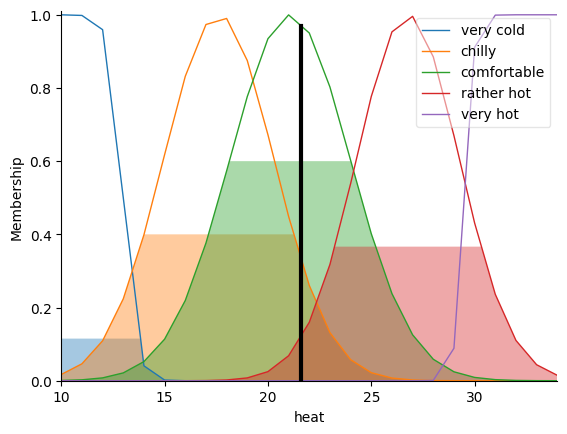

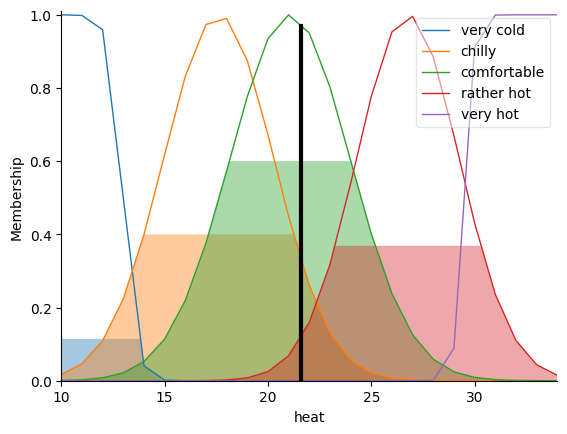

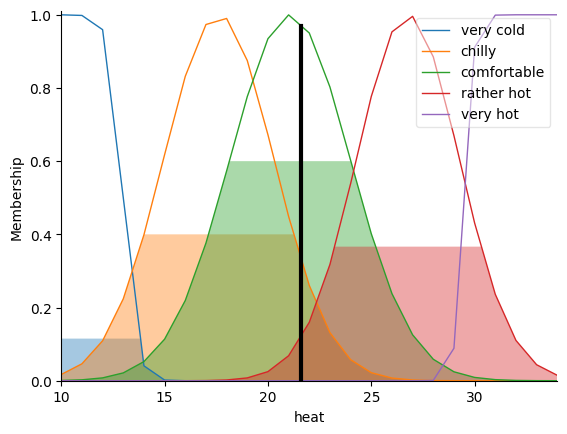

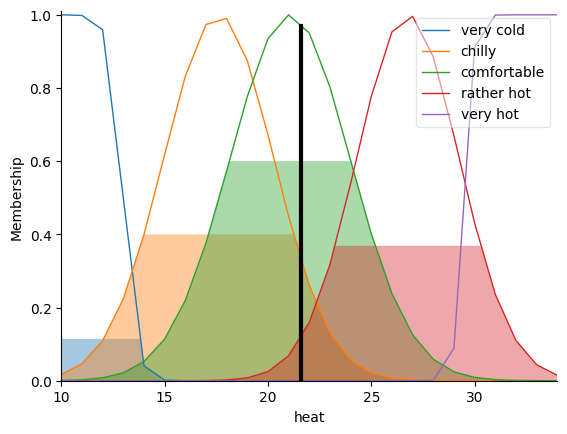

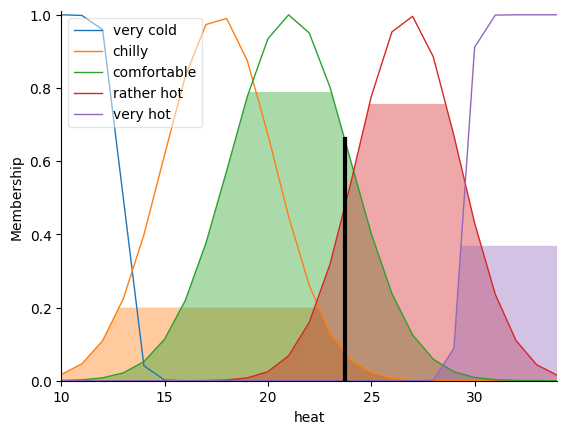

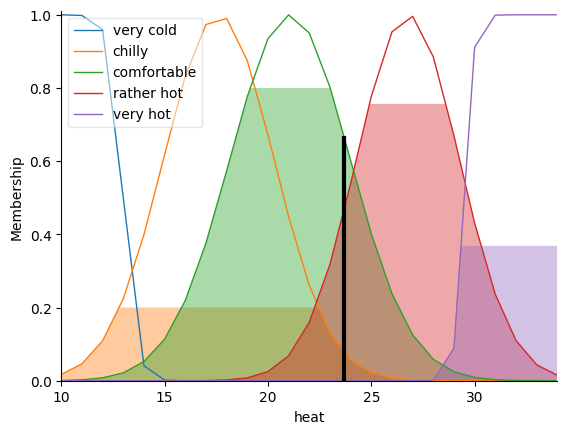

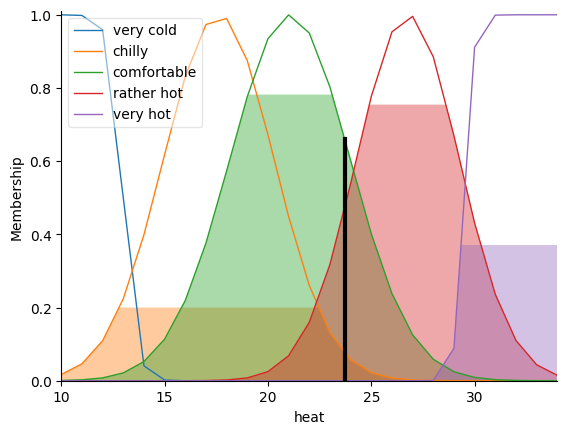

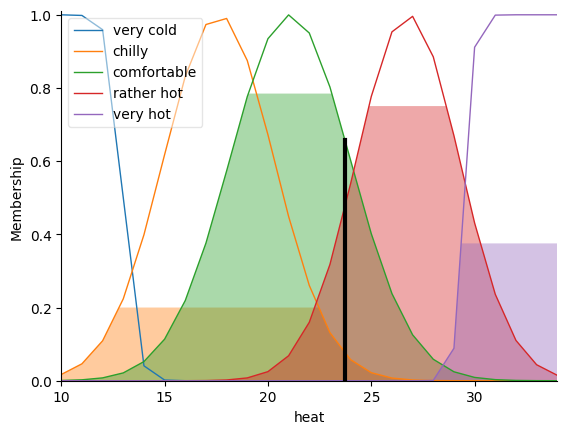

In [1]:

################################################## LIBRARIES #################################################################################
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import time  # to run the program multiple times
import requests  #for webpage reading and posting


def programma():
    ############################################### fuzzy I/O variables  ######################################################

    # Inputs
    temperature = ctrl.Antecedent(np.arange(-44, 86, 1), 'temperature')      # °C
    humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')     # %
    feeling = ctrl.Antecedent(np.arange(0, 11, 1), 'feeling')        # 0=cold ... 10=hot
    ecology = ctrl.Antecedent(np.arange(0, 11, 1), 'ecology')        # 0=very ecologically concerned ... 10=not concerned by ecology

    # Output
    heat = ctrl.Consequent(np.arange(10, 35, 1), 'heat')       # heating level °C

    # It's gonna show us to which temperature we should heat/cool the room.



    ############################################### membership functions ############################################################


    room = requests.get("http://localhost:5000/room").json()["room"]  #gets the room from the route  /room
    print("Using room:", room)


    #shapes of the membership functions for temperature and heating
    def temp_membership_func(var, b1, c1, s1, m1, s2, m2, s3 ,m3, b2, c2):
        # for the b parameter we set the mean of our data and for c the standard deviation, even though this is not totally accurate and we would need a curve fitting, we think these are relatively acceptable parameters
        var['very cold']    = fuzz.sigmf(var.universe, b=b1,  c=-c1)
        var['chilly']    = fuzz.gaussmf(var.universe, sigma=s1,  mean=m1)
        var['comfortable']  = fuzz.gaussmf(var.universe, sigma=s2,  mean=m2)
        var['rather hot']     = fuzz.gaussmf(var.universe, sigma=s3,  mean=m3)
        var['very hot']     = fuzz.sigmf(var.universe, b=b2,  c=c2)


    # membership values adapted to the type of room
    if room == 'bathroom':
        temp_membership_func(temperature, 15.38, 2.73, 2.60, 17.75, 1.91, 21.75, 2.10, 25.88, 28.68, 1.69)
        temp_membership_func(heat, 15.38, 2.73, 2.60, 17.75, 1.91, 21.75, 2.10, 25.88, 28.68, 1.69)

    elif room == 'kitchen':
        temp_membership_func(temperature, 12.75, 3.49, 3.14, 16.88, 3.55, 21.00, 3.98, 25.19, 28.25, 4.37)
        temp_membership_func(heat, 12.75, 3.49, 3.14, 16.88, 3.55, 21.00, 3.98, 25.19, 28.25, 4.37)

    elif room == 'bedroom':
        temp_membership_func(temperature, 13.39, 4.68, 2.06, 15.59, 3.08, 18.83, 2.76, 23.11, 25.08, 2.46)
        temp_membership_func(heat, 13.39, 4.68, 2.06, 15.59, 3.08, 18.83, 2.76, 23.11, 25.08, 2.46)

    elif room == 'living room': # room in living room or any other room (standard)
        temp_membership_func(temperature, 13.00, 3.16, 2.67, 17.62, 2.91, 21.07, 2.49, 26.77, 29.50, 4.66)
        temp_membership_func(heat, 13.00, 3.16, 2.67, 17.62, 2.91, 21.07, 2.49, 26.77, 29.50, 4.66)



    # according to https://atmotube.com/blog/ideal-household-humidity-level, a good humidity for inside is 40-50% --> 45% should be optimal
    humidity['low']    = fuzz.trapmf(humidity.universe, [0, 0, 0, 45])
    humidity['medium']     = fuzz.trimf(humidity.universe, [0, 45, 100])
    humidity['high']   = fuzz.trapmf(humidity.universe, [45, 100, 100, 100])

    feeling['too cold']    = fuzz.trapmf(feeling.universe, [0, 0, 0, 5])
    feeling['okay']   = fuzz.trimf(feeling.universe, [0, 5, 10])
    feeling['too hot']     = fuzz.trapmf(feeling.universe, [5, 10, 10, 10])

    ecology['not eco']    = fuzz.trapmf(ecology.universe, [0, 0, 0, 5])
    ecology['medium']   = fuzz.trimf(ecology.universe, [0, 5, 10])
    ecology['eco']     = fuzz.trapmf(ecology.universe, [5, 10, 10, 10])


    ############################################ fuzzy rules#################################################################
   

    # treating extreme temperature cases --> we set a comfortable temperature readardless of any other parameters
    r1 = ctrl.Rule(temperature['very hot'], heat['comfortable'])
    r2 = ctrl.Rule(temperature['very cold'], heat['comfortable'])

    # taking into accound the temperature (mild ones) and the feeling to set the heating target temperature
    r3 = ctrl.Rule(temperature['chilly'] & feeling['too cold'], heat['rather hot'])
    r4 = ctrl.Rule(temperature['chilly'] & feeling['too hot'], heat['very cold'])
    r5 = ctrl.Rule(temperature['rather hot'] & feeling['too cold'], heat['very hot'])
    r6 = ctrl.Rule(temperature['rather hot'] & feeling['too hot'], heat['chilly'])
    r7 = ctrl.Rule(temperature['chilly'] & feeling['okay'], heat['chilly'])
    r8 = ctrl.Rule(temperature['rather hot'] & feeling['okay'], heat['rather hot'])
    r9 = ctrl.Rule(temperature['comfortable'] & feeling['too hot'], heat['chilly'])
    r10 = ctrl.Rule(temperature['comfortable'] & feeling['okay'], heat['comfortable'])
    r11 = ctrl.Rule(temperature['comfortable'] & feeling['too cold'], heat['rather hot'])

    # taking into account the temperature and the ecology, the ecology dampens the changes
    r12 = ctrl.Rule((temperature['very cold'] | temperature['chilly']) & ecology['eco'], heat['chilly'])
    r13 = ctrl.Rule((temperature['very hot'] | temperature['rather hot']) & ecology['eco'], heat['rather hot'])
    r14 = ctrl.Rule((temperature['very cold'] | temperature['chilly']) & ecology['medium'], heat['comfortable'])
    r15 = ctrl.Rule((temperature['very hot'] | temperature['rather hot']) & ecology['medium'], heat['comfortable'])
    r16 = ctrl.Rule((temperature['very cold'] | temperature['chilly']) & ecology['not eco'], heat['rather hot'])
    r17 = ctrl.Rule((temperature['very hot'] | temperature['rather hot']) & ecology['not eco'], heat['chilly'])

    # taking into account the humidity, the humidity makes the feelings more extreme, so the temperature should be closer to a comfortable one if the humidity is high
    # the humidity only has a limited impact on the output as some other parameters are way more important
    r18 = ctrl.Rule(humidity['high'], heat['comfortable'])
    r19 = ctrl.Rule(humidity['medium'] & feeling['too hot'], heat['comfortable'])
    r20 = ctrl.Rule(humidity['medium'] & feeling['too cold'], heat['comfortable'])

    heating_ctrl = ctrl.ControlSystem([r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20])
    heating_sim = ctrl.ControlSystemSimulation(heating_ctrl)



    ########################## Fuzzy computation ##########################################


    #get sensor's records from flask API

    sensor = requests.get("http://localhost:5000/data").json()

    t = sensor["temperature"]
    h = sensor["humidity"]

    print("Sensor:", sensor)

    #get user's preferences (feeling, ecology)

    sliders = requests.get("http://localhost:5000/sliders").json()

    feeling = sliders["feeling"]
    ecology = sliders["ecology"]

    print("Sliders:", sliders)



    #heating_sim.input['temperature'] = 17
    heating_sim.input['temperature'] = t  
    heating_sim.input['humidity'] = h
    heating_sim.input['feeling'] = feeling
    heating_sim.input['ecology'] = ecology

    heating_sim.compute()
    risultato = heating_sim.output['heat']
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    #print( "Computed heat output:", heating_sim.output['heat'])
    print("actual temperature", t  , "Computed heat output:", heating_sim.output['heat'])
    heat.view(sim=heating_sim)

    r = requests.post("http://localhost:5000/heat", json={"heat": risultato})

#barbarian solution to have the program refresh each 8 seconds
while True:
    programma()
    time.sleep(2)